<a href="https://colab.research.google.com/github/yusufdemirci7/CS412_PROJECT/blob/main/RegressionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MSE on original scale: 1043621.1925
MAE on original scale: 277.7227
Log MSE: 0.4712
R-squared: 0.7980
Sample Predictions:
        Actual    Predicted
174773   128.0   120.737434
144713    32.0    24.368484
89574     16.0    12.857616
124231  1419.0   501.429443
87457   1068.0  1437.193359


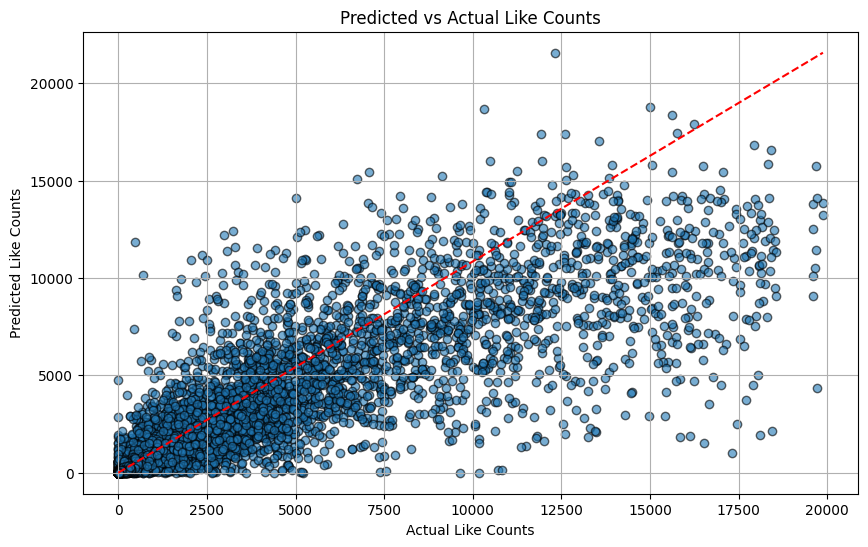

Predictions saved to predicted_vs_actual_values_3.csv
             username  predicted_like_count
0  mesuterginofficial            536.094360
1    daricabelediyesi            285.256012
2            fikriyat           6252.604980
3           obenalkan          15752.875000
4         kaledehayat             64.992104


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import IsolationForest

# Load the data
file_path = 'training_data_for_reg.csv'
df_kk = pd.read_csv(file_path)

# Handle missing values
def handle_missing_values(df, feature_columns):
    imputer = SimpleImputer(strategy='mean')  # Use mean strategy for numerical features
    df[feature_columns] = imputer.fit_transform(df[feature_columns])
    return df

# Transform target variable (e.g., log transformation)
def transform_target_variable(df, target_col, transformation='log'):
    if transformation == 'sqrt':
        df['transformed_' + target_col] = np.sqrt(df[target_col].fillna(0))
    elif transformation == 'log':
        df['transformed_' + target_col] = np.log1p(df[target_col].fillna(0))
    elif transformation == 'cube_root':
        df['transformed_' + target_col] = np.cbrt(df[target_col].fillna(0))
    else:
        raise ValueError("Unsupported transformation type. Use 'sqrt', 'log', or 'cube_root'.")
    return df

# Outlier Detection with Isolation Forest
def detect_outliers_isolation_forest(df, target_col, contamination=0.05):
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df['outlier'] = isolation_forest.fit_predict(df[[target_col]])
    df['outlier'] = df['outlier'].map({1: False, -1: True})
    return df

# Train and evaluate the model with tuning
def train_and_evaluate_model_with_tuning(df, feature_columns, target_col):
    X = df[feature_columns]
    y = df[target_col]  # Transformed target variable
    y = y.fillna(0)  # Ensure no NaNs in the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model
    model = xgb.XGBRegressor(random_state=42)

    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_estimators': 300,  # n_estimators will be passed to GridSearchCV or fit method instead of num_boost_round
    }

    # Train the model with the specified parameters
    model.set_params(**param)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_transformed = model.predict(X_test)

    # Revert transformation (log in this case)
    y_pred = np.expm1(y_pred_transformed)  # Exponentiate predictions
    y_test_original = np.expm1(y_test)  # Exponentiate test data to revert to original scale

    # Evaluate the model using original scale
    mse = mean_squared_error(y_test_original, y_pred)
    mae = mean_absolute_error(y_test_original, y_pred)

    # Evaluate the model using Log MSE
    log_y_test = np.log1p(y_test_original)
    log_y_pred = np.log1p(y_pred)
    log_mse = mean_squared_error(log_y_test, log_y_pred)

    # Calculate R-squared
    r2 = r2_score(y_test_original, y_pred)

    print(f"MSE on original scale: {mse:.4f}")
    print(f"MAE on original scale: {mae:.4f}")
    print(f"Log MSE: {log_mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    return model, X_test, y_test_original, y_pred

# Plot predictions
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', linestyle='--')  # Diagonal line
    plt.title('Predicted vs Actual Like Counts')
    plt.xlabel('Actual Like Counts')
    plt.ylabel('Predicted Like Counts')
    plt.grid(True)
    plt.show()

# Save predictions and actual values to a CSV file
def save_predictions_to_csv(y_test, y_pred, file_name='predicted_vs_actual_values.csv'):
    results_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred
    })
    results_df.to_csv(file_name, index=False)
    print(f"Predictions saved to {file_name}")

# Transform the target variable
df_kk = transform_target_variable(df_kk, target_col='like_count', transformation='log')

# Handle missing values
feature_columns = [
    'avg_like_count', 'std_like_count', 'coefficient_of_variation',
    'engagement_rate', 'follower_count',
    'comments_count', 'avg_comment_count', 'avg_comment_to_like_ratio'
]
df_kk = handle_missing_values(df_kk, feature_columns)

# Outlier Detection using Isolation Forest
df_kk = detect_outliers_isolation_forest(df_kk, target_col='like_count')

# Remove outliers from the data
df_kk_cleaned = df_kk[df_kk['outlier'] == False]

# Train and evaluate the model with cleaned data
best_model, X_test, y_test, y_pred = train_and_evaluate_model_with_tuning(df_kk_cleaned, feature_columns, target_col='transformed_like_count')

# Inspect results
print("Sample Predictions:")
print(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head())

# Plot results
plot_predictions(y_test, y_pred)

# Save the results to a CSV file
save_predictions_to_csv(y_test, y_pred, file_name='predicted_vs_actual_values_3.csv')

df_test = pd.read_csv('to_be_predicted_3.csv')

# Handle missing values in the test data
df_test = handle_missing_values(df_test, feature_columns)

# Step 2: Make predictions on the new test data
# Select the features that were used for training the model
X_test_new = df_test[feature_columns]

# Make predictions on the new data (using the trained model)
y_pred_test_transformed = best_model.predict(X_test_new)

# Revert the transformation (log transformation)
y_pred_test = np.expm1(y_pred_test_transformed)

# Step 3: Insert the predictions back into the DataFrame
df_test['predicted_like_count'] = y_pred_test

# Step 4: Inspect the result
print(df_test[['username', 'predicted_like_count']].head())

# Optionally, save the DataFrame with predictions to a CSV file
df_test.to_csv('predicted_like_counts_for_3_median.csv', index=False)
